In [21]:
import json
import numpy as np
import random
from tqdm import tqdm
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.decomposition import PCA
import re
import matplotlib.pyplot as plt

In [4]:
def rand_emot():
    e = ["(o_o)",":-)",":P",":D","x)","ᓚᘏᗢ","╯°□°）╯︵ ┻━┻",":)",
         "*<:-)","^_^","(⌐■_■)","¯\_(ツ)_/¯", "(T_T)",":o","OwO",
        "( ͡❛ ͜ʖ ͡❛)","(̶◉͛‿◉̶)","( ≖.≖)","(ㆆ_ㆆ)","ʕ•́ᴥ•̀ʔっ","( ◡́.◡̀)","(^◡^ )"]
    return random.choice(e)

def load_files():
    text_pairs = [] #Would be nice to have as np.array
    labels = []
    fandom = []
    
    pair_id = []
    true_id = []
    
    #Load truth JSON
    for line in open('data/modified/train_truth.jsonl'):
        d = json.loads(line.strip())
        labels.append(int(d['same']))
        true_id.append(d['id'])

    #Load actual fanfic.
    print("loading fanfic...",rand_emot())
    for line in tqdm(open('data/modified/train_pair.jsonl')):
        d = json.loads(line.strip())
        text_pairs.append(d['pair'])
        fandom.append(d['fandoms'])
        pair_id.append(d['id'])

    print("done loading",rand_emot())
    
    return text_pairs, labels, fandom, pair_id, true_id

In [5]:
text_pairs, labels, fandom, pair_id, true_id = load_files()

356it [00:00, 1717.49it/s]

loading fanfic... (^◡^ )


1578it [00:00, 1761.44it/s]

done loading ( ◡́.◡̀)


In [6]:
def word_freq(text_pair):
    fdist0 = nltk.FreqDist(text_pair[0])
    fdist1 = nltk.FreqDist(text_pair[1])
    
    return [fdist0, fdist1]

def word_freq_single(text):
    fdist = nltk.FreqDist(text)
    return fdist

def tokenize(text_pair):
    return [nltk.word_tokenize(text_pair[0]),nltk.word_tokenize(text_pair[1])]

def vector_freq_dist(freq_dists): #I don't think this works...
    return [list(freq_dists[0].values()), list(freq_dists[1].values())]

def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [7]:
def create_corpus(text_pairs):
    '''input all text pairs to create a corpus'''
    corpus = [x[i] for x in text_pairs for i in range(len(x))]
    return corpus

def fit_tfidf(corpus):
    vectorizer = TfidfVectorizer()
    print("training vectorizer...",rand_emot())
    X = vectorizer.fit_transform(corpus)
    print("vectorizer fit!", rand_emot())
    
    
    df = pd.DataFrame(X[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)
    
    return X, df

In [8]:
corpus = create_corpus(text_pairs)

In [67]:
#tf-idf on the raw text. Likely not useful, as you can see, it is sesnitive to the fandom.
raw_tfidf, tfidf_df = fit_tfidf(corpus)

training vectorizer... (o_o)
vectorizer fitted! (̶◉͛‿◉̶)


In [68]:
tfidf_df.head(10)

,TF-IDF
the,0.389299
to,0.295670
kuroko,0.283424
judgement,0.247891
was,0.184794
and,0.182388
it,0.182330
that,0.172474
she,0.169618
her,0.146488


In [69]:
#Attempting to perform tf-idf on only symbols.
def isolate_symbols(corpus):
    #Add \d to omit digits too.
    return re.findall("[^a-zA-Z\s:]", ' '.join(corpus))

symbols = isolate_symbols(corpus)

#Okay, tf-idf doesn't work with symbols. I'll convert them to made-up words

In [70]:
#Whack function that converts symbols to letters...
def symbol2word(symbols):
    '''Takes in set of symbols and convert them to unique words'''
    symbols = list(symbols)
    sym2word = {}
    chars = [0,0,0]
    
    for i in range(len(symbols)):
        chars[2] = add_one(chars[2])
        
        if chars[2] % 58 == 0:
            chars[1] = add_one(chars[1])
            chars[2] = 0
        
        if chars[1] % 58 == 0 and chars[1] != 0:
            chars[0] = add_one(chars[0])
            chars[1] = 0
        
        
        sym2word[symbols[i]] = 'XX'+chr(chars[0]+65)+chr(chars[1]+65)+chr(chars[2]+65)
    
    return sym2word

def add_one(x):
    if x == 91-66:
        return x + 7
    return x + 1

def replace_symbols(symwords, corpus):
    for i, text in tqdm(enumerate(corpus)):
        text = nltk.word_tokenize(text)
        text = replace(text, symwords)
        corpus[i] = text
    return corpus

def replace(tokens, dictionary):
    return [dictionary.get(item, item) for item in tokens]

def chunk_replace(corpus):
    start = 0
    for i in range(0,int(len(corpus)/100),100):
        corpus[start:i] = replace_symbols(symwords, corpus[start:i])
        start = i
    corpus[start:] = replace_symbols(symwords, corpus[start:])
    
    return corpus

In [71]:
#Convert symbols to words
symwords = symbol2word(set(symbols))

#DESTROY corpus by replacing symbols with their word.
corpus = replace_symbols(symwords, corpus)

3156it [01:55, 27.41it/s]


In [72]:
print("joining corpus...",rand_emot())
tfidf_sym, sym_df = fit_tfidf([' '.join(x) for x in corpus])

joining corpus... ╯°□°）╯︵ ┻━┻
training vectorizer... OwO
vectorizer fitted! (⌐■_■)


In [73]:
sym_df.head(10)

,TF-IDF
xxaeq,0.495362
xxadh,0.470565
the,0.281537
to,0.213825
kuroko,0.204969
judgement,0.179272
was,0.133641
and,0.131901
it,0.131859
that,0.124731


In [ ]:
key_list = list(symwords.keys())
val_list = list(symwords.values())

key_list[val_list.index('XXADM')], key_list[val_list.index('XXAAE')]

In [20]:
## POS Tagging and ngrams
tokens = nltk.word_tokenize(corpus[0])
pos_tags = nltk.pos_tag(tokens)
pos_bigrams = nltk.bigrams(pos_tags)

In [7]:
def compute_lix(text):
    tokens = nltk.word_tokenize(text)
    splt = text.split()
    o = len(splt)+1
    p = len([x for x in tokens if x=='.'])+1
    l = len([x for x in tokens if len(x)>6])+1
    
    return (o/p)+((l*100)/o)

In [22]:
for text in corpus[:10]:
    print(compute_lix(text))

29.910954831914932
30.709476503232075
34.64747315241397
31.16576505295295
35.736950980754315
27.826830313919487
23.657931484369428
30.435502148277408
29.67444070920108
27.62315961549868


In [8]:
def tokenize_no_symbols(text):
    return nltk.word_tokenize(re.sub(r'[^\w]', ' ', text))

def get_fdist_yule(text):
    text = tokenize_no_symbols(text)
    fdist = word_freq_single(text)
    return fdist
        
def get_num_unique_words(text):
    text = tokenize_no_symbols(text.lower())
    return len(set(text))
        
def yules_k(text):
    C = 10000
    splt = text.split()
    N = len(splt)
    Vn = get_num_unique_words(text)
    fdist = get_fdist_yule(text)
    max_word = fdist.most_common()[0][1]
    
    var = 0
    
    for m in range(max_word):
        Vmn = len([x for x in fdist if g[x]==m])
        mNs = np.power(m/N,2)
        
        var += Vmn*mNs
    
    return C*(-1/N+var)
        
        

In [145]:
#I am not 100% sure I implemented Yule's K the right way. 
for i in corpus[:10]:
    k,lix = yules_k(i), compute_lix(i)
    print(k, lix, k-lix)

54.62083541967105 29.910954831914932 24.70988058775612
45.2408374369652 30.709476503232075 14.531360933733126
56.48303057910138 34.64747315241397 21.83555742668741
66.12776191414503 31.16576505295295 34.96199686119208
64.91155078895463 35.736950980754315 29.174599808200313
60.8559890488825 27.826830313919487 33.02915873496301
59.63438363020951 23.657931484369428 35.976452145840085
68.88038916588879 30.435502148277408 38.44488701761138
63.03121014939809 29.67444070920108 33.35676944019701
67.15162000629128 27.62315961549868 39.5284603907926


In [114]:
g = get_fdist_yule(corpus[0])
g.items(), key=lambda x: x[1])[::-1][0][1]

135

In [41]:
#We can also use CountVectorizer
c_vec = CountVectorizer()
cX = c_vec.fit_transform(corpus)
cX.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [42]:
#Hmmm... 
tfidf_vec = TfidfVectorizer()
tfidfX = tfidf_vec.fit_transform(corpus)
tfidfX.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
logreg = LogisticRegression(max_iter=1000)
cx_arr = cX.toarray()
cvec_pairs = [np.concatenate([cx_arr[x],cx_arr[x+1]]) for x in range(0,len(cx_arr),2)]

cvec_train, cvec_test, labels_train, labels_test = train_test_split(cvec_pairs, labels)
len(cvec_train)

1183

In [40]:
#Slow!
logreg.fit(cvec_train, labels_train)

LogisticRegression(max_iter=1000)

In [44]:
#62% accuracy just from word freq on raw text.
logreg.score(cvec_test, labels_test)

0.6227848101265823

In [44]:
tfidf_arr = tfidfX.toarray()
tfidf_pairs = [np.concatenate([tfidf_arr[x],tfidf_arr[x+1]]) for x in range(0,len(tfidf_arr),2)]

tf_train, tf_test, tf_labels_train, tf_labels_test = train_test_split(tfidf_pairs, labels)
len(tf_train)

1183

In [49]:
#64% accuracy on tfidf on raw text.
logreg.fit(tf_train, tf_labels_train)
logreg.score(tf_test, tf_labels_test)

0.6481012658227848

In [63]:
#BAD result!
logreg.fit(np.hstack([tf_train,cvec_train]), tf_labels_train)
logreg.score(np.hstack([tf_test,cvec_test]), tf_labels_test)

0.5392405063291139

In [77]:
tfsym_arr = tfidfX.toarray()
tfsym_pairs = [np.concatenate([tfsym_arr[x],tfsym_arr[x+1]]) for x in range(0,len(tfsym_arr),2)]

tfsym_train, tfsym_test, tfsym_labels_train, tfsym_labels_test = train_test_split(tfsym_pairs, labels)

In [78]:
#61% 
logreg.fit(tfsym_train, tfsym_labels_train)
logreg.score(tfsym_test, tfsym_labels_test)

0.6151898734177215

In [27]:
lix_vec = np.array([compute_lix(x) for x in corpus])
yule_vec = np.array([yules_k(x) for x in corpus])

NameError: name 'g' is not defined

In [21]:
lix_pairs = [np.hstack([lix_vec[x],lix_vec[x+1]]) for x in range(0,len(lix_vec),2)]
lix_train, lix_test, lix_labels_train, lix_labels_test = train_test_split(lix_pairs, labels)

yule_pairs = [np.hstack([yule_vec[x],yule_vec[x+1]]) for x in range(0,len(yule_vec),2)]
yule_train, yule_test, yule_labels_train, yule_labels_test = train_test_split()

In [26]:
logreg.fit(lix_train, lix_labels_train)
logreg.score(lix_test, lix_labels_test)

0.5088607594936709

In [35]:
def plot_pcs(pcs, target, labels, ctitle=""):   
    group1 = pcs[target==0]
    group2 = pcs[target==1]
    
    plt.scatter(group1[:,0], group1[:,1], cmap='jet', label=labels[0], s=1)
    plt.scatter(group2[:,0], group2[:,1], cmap='jet', label=labels[1], s=1)
    
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend(loc="best")
    plt.title(ctitle)

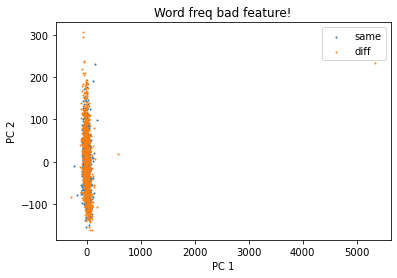

In [37]:
pca = PCA(n_components=2)
cx_arr = cX.toarray()
cvec_pairs = [np.concatenate([cx_arr[x],cx_arr[x+1]]) for x in range(0,len(cx_arr),2)]

pcs = pca.fit_transform(cvec_pairs)

plot_pcs(pcs, np.array(labels), ("same", "diff"), ctitle="Word freq bad feature!")

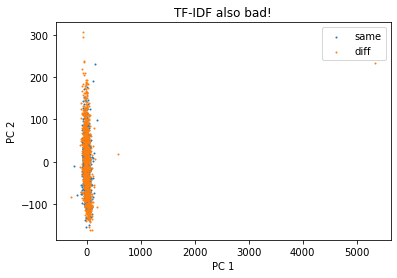

In [46]:
tf_pcs = pca.fit_transform(tfidf_pairs)
plot_pcs(pcs, np.array(labels), ("same", "diff"), ctitle="TF-IDF also bad!")

In [33]:
pcs.shape

(3156, 2)